In [56]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import time
import random
import pickle

# Classifier Training
The following block contains the training of the SVM classifier using a dataset composed of 32 x 32 images of vehicles and not vehicles. The images are first processed, by extracting color and shape information and then a linear SVC is trained and exported.

In [33]:
## Importing vehicle and non-vehicles images

def import_images(directory):
    """
    This function takes the path of a directorty and returns a list of images extracted from every depending directory
    """
    # Extract folder names in the given directory
    folder_names = [name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))]
    
    # Iterate through folders to extract images
    images_list = []
    for folder in folder_names:
        folder_path = os.path.join(directory, folder)
        pattern = os.path.join(folder_path, '*.png')
        image_files = glob.glob(pattern)
        image_files = sorted(glob.glob(pattern))
        # Loop through the list of filenames and load each image
        for filename in image_files:
            image = cv2.imread(filename)
            images_list.append(image)
    
    return images_list


current_directory = os.getcwd()
vehicles_directory = os.path.join(current_directory, 'vehicles')
non_vehicles_directory = os.path.join(current_directory, 'non-vehicles')

vehicles_images = import_images(vehicles_directory)
non_vehicles_images = import_images(non_vehicles_directory)
    
print(f'Number of images of vehicles imported: {len(vehicles_images)}')
print(f'Number of images of non-vehicles imported: {len(non_vehicles_images)}')

Number of images of vehicles imported: 8792
Number of images of non-vehicles imported: 8968


### Color histograms
The first feature extracted from the image is about the color information and it is simply the collection of the color histograms across the 3 channels. In the following example, the RGB representation of the image is used but other representation are also possible. 

In [3]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

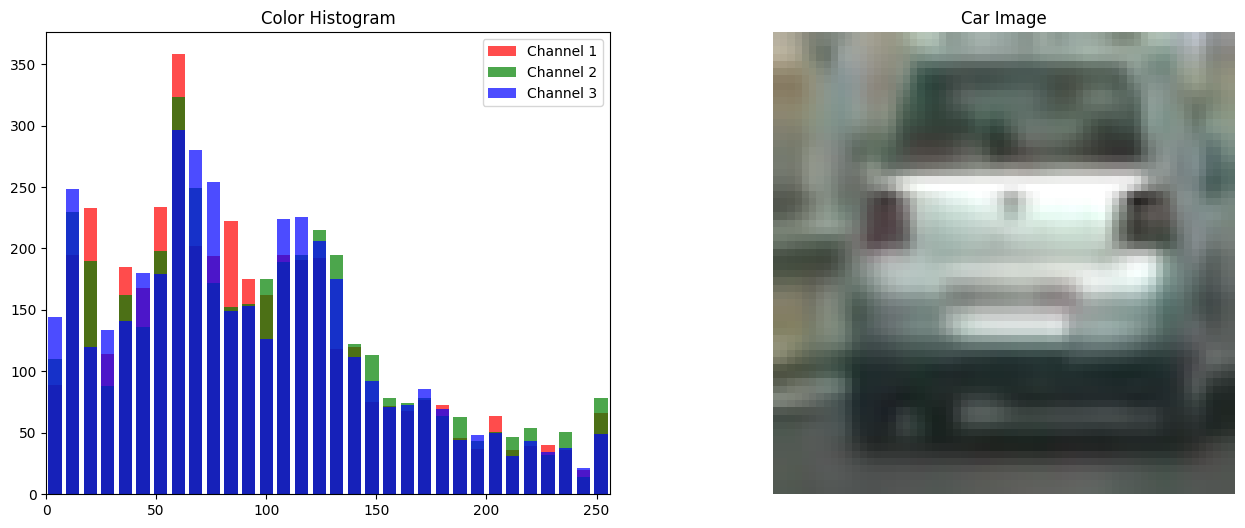

In [47]:
car = random.choice(vehicles_images)
hist_features = color_hist(car)
nbins = 32

bin_edges = np.linspace(0, 256, nbins+1)
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1]) / 2

bin_edges = np.linspace(0, 256, nbins+1)
bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1]) / 2

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot color histogram
axes[0].bar(bin_centers, hist_features[0:nbins], width=6, color='r', alpha=0.7, label='Channel 1')
axes[0].bar(bin_centers, hist_features[nbins:2*nbins], width=6, color='g', alpha=0.7, label='Channel 2')
axes[0].bar(bin_centers, hist_features[2*nbins:], width=6, color='b', alpha=0.7, label='Channel 3')
axes[0].set_xlim(0, 256)
axes[0].set_title('Color Histogram')
axes[0].legend()

# Plot car image
axes[1].imshow(car[...,::-1])
axes[1].set_title('Car Image')
axes[1].axis('off')

plt.show()

## Spatial binning
To retain some information about the position of the pixels and their respective intensity, we use a flattened version of the image as obtained from the following function.

In [48]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

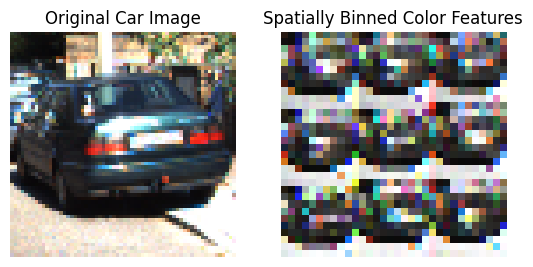

In [53]:
car = random.choice(vehicles_images)

# Plot the original car image
plt.subplot(1, 2, 1)
plt.imshow(car[...,::-1])
plt.title('Original Car Image')
plt.axis('off')

# Compute spatially binned color features
spatial_features = bin_spatial(car)

# Reshape the spatial_features array to match the original image shape
spatial_features_shape = (32, 32, 3)  # Assuming size is (height, width)
spatial_features_image = spatial_features.reshape(spatial_features_shape)

# Display the spatially binned color features as an image
plt.subplot(1, 2, 2)
plt.imshow(spatial_features_image)
plt.title('Spatially Binned Color Features')
plt.axis('off')

plt.show()

## HOG features
In addition to color features, it's also important to obtain some information about the shape of the object in the image. To do this we construct a histogram of gradient directions weighted by their magnitude using the function by SciKit-Image.

In [54]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

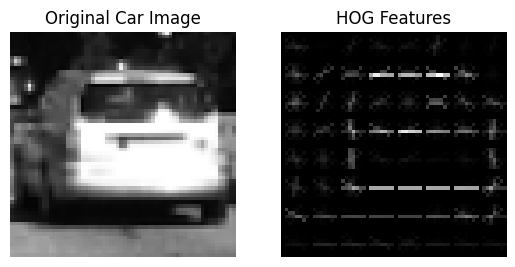

In [82]:
car = random.choice(vehicles_images)
gray_car = cv2.cvtColor(car, cv2.COLOR_BGR2GRAY)

# Parameters for HOG feature extraction
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Compute HOG features and HOG image
features, hog_image = get_hog_features(gray_car, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot both the original car image and its HOG representation
plt.subplot(1, 2, 1)
plt.imshow(car[:,:,-1], cmap='gray')
plt.title('Original Car Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Features')
plt.axis('off')

plt.show()

Having defined all the single functions we can define a general function the 3 described features from each image of the dataset. Finally, having defined the parameters, we can train the SVC model and export it. 

In [6]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        img_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            img_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            # Append the new feature vector to the features list
            img_features.append(hog_features)
            
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features

In [98]:
color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9          # HOG orientations
pix_per_cell   = 8          # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size   = (32, 32)   # Spatial binning dimensions
hist_bins      = 32         # Number of histogram bins
spatial_feat   = True       # Spatial features on or off
hist_feat      = True       # Histogram features on or off
hog_feat       = True       # HOG features on or off

In [8]:
# Record the start time
start_time = time.time()

# Extract features
car_features = extract_features(vehicles_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(non_vehicles_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

end_time = time.time()
elapsed_time = end_time - start_time

print("Time taken to extract features:", elapsed_time, "seconds")

Time taken to extract features: 144.4013273715973 seconds


In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell, 
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(dual=True)
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
6.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9927


In [95]:
def extract_img_features(img, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        spatial_features = np.ravel(spatial_features) 
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        hist_features = np.ravel(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
    return np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)

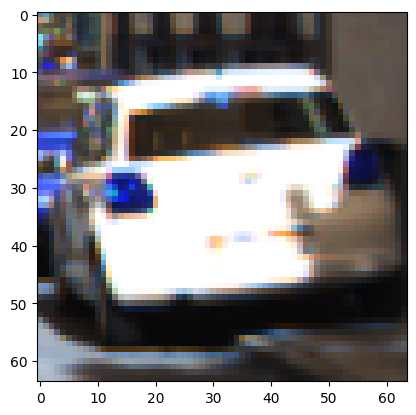

The image represents a car


In [102]:
# Randomly select an image from the list
car = random.choice(vehicles_images)
plt.imshow(car)
plt.show()

features = extract_img_features(car, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

if svc.predict(features) == 1:
    print('The image represents a car')
else:
    print('The image does not represent a car')

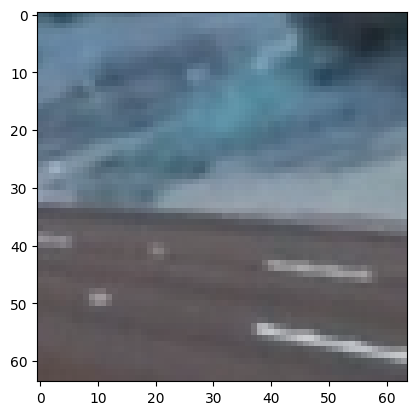

The image does not represent a car


In [109]:
# Randomly select an image from the list
not_car = random.choice(non_vehicles_images)
plt.imshow(not_car)
plt.show()

features = extract_img_features(not_car, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

if svc.predict(features) == 1:
    print('The image represents a car')
else:
    print('The image does not represent a car')

In [110]:
# Save data to pickle file
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )

print('Classifier parameters were saved to file')

Classifier parameters were saved to file


In [83]:
# Delete all stored variables
%reset -f

## Deployment of model
Having trained the model we can finally use it on the frames of the video. In the following cells, a sliding window method for identifying cars, based on a color and gradient thresholding, is used in order to create a heatmap, which represents the likelihood of each region of containing a car. Finally, the main functions are implemented in 'main.py' and tested in a loop.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import time
import random
import pickle

In [85]:
print('Loading Classifier parameters...')
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

print('Loading is done')

Loading Classifier parameters...
Loading is done


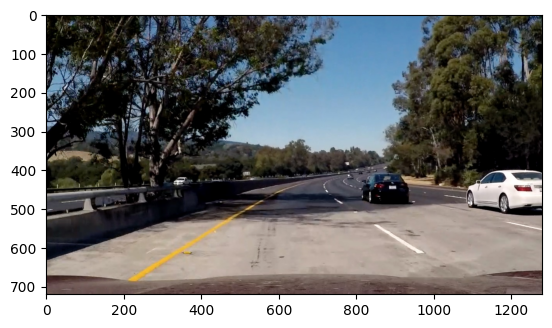

In [2]:
# Get the current directory
current_dir = os.getcwd()

# Import image with cars
path = os.path.join(current_dir, 'test_images/test5.jpg')
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [6]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def color_hist(img, nbins=32):  #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))


from skimage.feature import hog


def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualize=vis, feature_vector=feature_vec)
        return features

### Color and Gradient Thresholding
One possible way to identify cars in the image is to threshold the image in such a way to robustly highlight cars and then test each candidate point to see if its neighbouring region actually contains a car. This is achieved in the following cells.

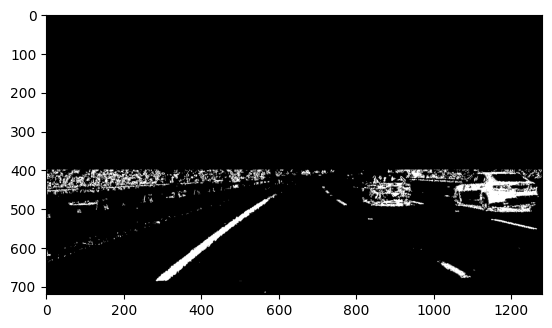

In [90]:
# Import image with cars
path = os.path.join(current_dir, 'test_images/test1.jpg')
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to HLS color space
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

# Extract the S (saturation) channel
s_channel = hls[:, :, 2]

# Apply Sobel operator in the x direction to the S channel
sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)

# Take the absolute value of the derivative
abs_sobelx = np.absolute(sobelx)

# Scale to 8-bit (0 - 255)
scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 150
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
combined_binary[:400, :] = 0

# Display the combined binary image
plt.imshow(combined_binary*255, cmap='gray')
plt.show()

In [8]:
def slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None],
                  xy_window=(50, 50), xy_overlap=(0.25, 0.25), scales=[1.0, 1.5, 2.0], min_pixels=1000):
    windows = []
    for scale in scales:
        # Rescale the image
        scaled_image = cv2.resize(image, (int(image.shape[1] / scale), int(image.shape[0] / scale)))

        # Define the span of the region to be searched
        x_start = x_start_stop[0] if x_start_stop[0] is not None else 0
        x_stop = x_start_stop[1] if x_start_stop[1] is not None else scaled_image.shape[1]
        y_start = y_start_stop[0] if y_start_stop[0] is not None else 0
        y_stop = y_start_stop[1] if y_start_stop[1] is not None else scaled_image.shape[0]

        # Compute the number of pixels to step in x and y
        x_step = int(xy_window[0] * xy_overlap[0])
        y_step = int(xy_window[1] * xy_overlap[1])

        # Compute the number of windows in x and y
        x_windows = int((x_stop - x_start - xy_window[0]) / x_step) + 1
        y_windows = int((y_stop - y_start - xy_window[1]) / y_step) + 1

        # Loop through each window position
        for ys in range(y_windows):
            for xs in range(x_windows):
                # Calculate window position
                startx = xs * x_step + x_start
                endx = startx + xy_window[0]
                starty = ys * y_step + y_start
                endy = starty + xy_window[1]

                # Extract window from the image
                window = scaled_image[starty:endy, startx:endx]

                # Check if the number of non-zero pixels exceeds the threshold
                if np.sum(window != 0) > min_pixels*scale:
                    # Calculate centroid of the window and convert to original image coordinates
                    centroid = ((startx + endx) / 2 * scale, (starty + endy) / 2 * scale)
                    windows.append(centroid)

    return windows

windows = slide_window(combined_binary, y_start_stop=[400, image.shape[0]])
print(len(windows))

110


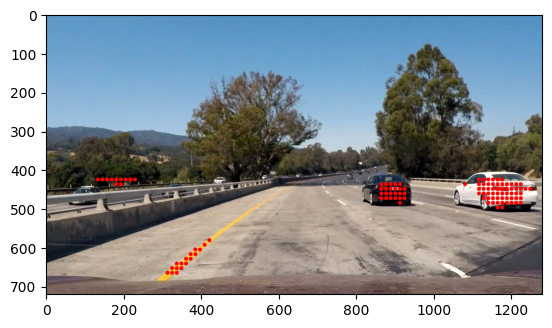

In [9]:
# Draw points on the original image at the centroids of detected windows
draw_image = np.copy(image)
for centroid in windows:
    cv2.circle(draw_image, (int(centroid[0]), int(centroid[1])), 5, (255, 0, 0), -1)  # Draw a green circle

# Display the image with the detected points
plt.imshow(draw_image)
plt.show()

In [10]:
def extract_img_features(img, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        spatial_features = np.ravel(spatial_features) 
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        hist_features = np.ravel(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
    return np.concatenate((spatial_features, hist_features, hog_features)).reshape(1, -1)

## Heatmap generation
By using the above defined function, we are able to detect cars and build a heatmap, which indicates the likelihood of each point being that of a car. We can see the same car is identified multiple times, since we are performing the search along different scales, making the heatmap hotter in some regions, hence improving the ability to correctly identify images. It can happen that some non-cars are identified as such, but by integrating the heatmap along multiple frames we are able to disregard outliers. 

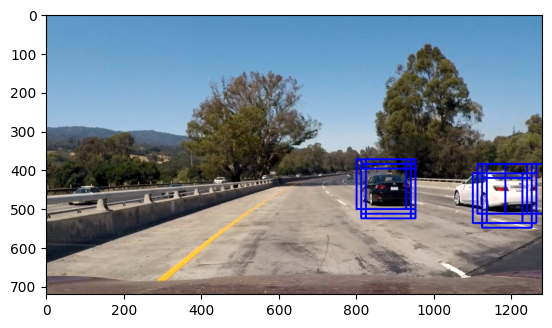

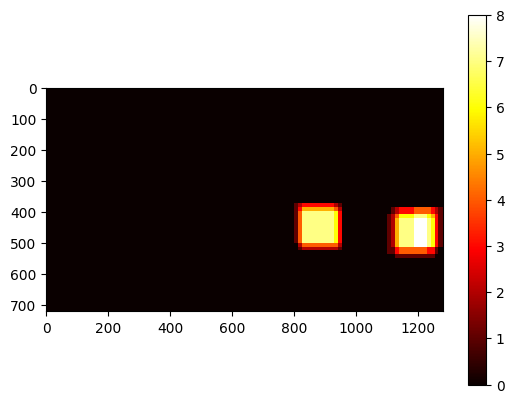

Number of identified cars:  15
Number of candidate points:  110
(720, 1280, 3)


In [11]:
draw_image = np.copy(image)
heat_map = np.zeros(image.shape[:2])

offsets_array = np.arange(10, 150, 10)
offsets = [64]

# Concatenate all windows and offsets
windows_offsets = [(x, y, offset) for x, y in windows for offset in offsets]

# Resize windows to a fixed size beforehand and extract features
resized_windows = [cv2.resize(image[max(int(y - offset), 0):min(int(y + offset), image.shape[0]),
                                    max(int(x - offset), 0):min(int(x + offset), image.shape[1])], (64, 64))
                   for x, y, offset in windows_offsets]
    
# Extract features for all windows
features = [extract_img_features(window, color_space='YCrCb', hog_channel='ALL') for window in resized_windows]

# Transform features
test_features = X_scaler.transform(np.concatenate(features))

# Predict all windows at once
predictions = svc.predict(test_features)

n_identified_cars = np.sum(predictions == 1)

for (x, y, offset), prediction in zip(windows_offsets, predictions):
    if prediction == 1:
        top_left = (int(x - offset), int(y - offset))
        bottom_right = (int(x + offset), int(y + offset))
        cv2.rectangle(draw_image, top_left, bottom_right, (0, 0, 255), 3)
        heat_map[int(y - offset):int(y + offset), int(x - offset):int(x + offset)] += 1

plt.imshow(draw_image)
plt.show()

plt.imshow(heat_map, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color bar indicating the scale
plt.show()

print('Number of identified cars: ', n_identified_cars)
print('Number of candidate points: ', len(windows) * len(offsets))

print(image.shape)


## Loop and video
Finally, we can call the VehicleDetectionTracking class and create the video

In [87]:
from main import VehicleDetectionTracking
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Get the current directory
current_dir = os.getcwd()
# Import project video
video_path = os.path.join(current_dir, 'test_videos/project_video.mp4')

cap = cv2.VideoCapture(video_path)

In [98]:
vdt = VehicleDetectionTracking()

cap = cv2.VideoCapture(video_path)
frame_rate = cap.get(cv2.CAP_PROP_FPS)  # Get the frame rate of the video
start_time = 38 # Start time in seconds
end_time = 80  # End time in seconds
total_frames = int(frame_rate * (end_time - start_time))  # Total frames to display for the given duration

# Seek to the start time
cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)
frame_count = 0

# Represent identified cars
while cap.isOpened():
    ret, frame = cap.read()
    if not ret or frame_count >= total_frames or cv2.waitKey(1) == ord('q'):
        break
    
    draw_image = vdt.process_new_frame(frame)
    cv2.imshow('Detected cars', draw_image)
    

    frame_count += 1
    
cap.release()

cv2.destroyAllWindows()

Loading Classifier parameters...
Loading is done


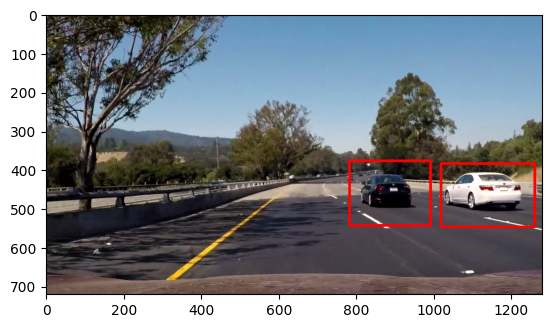

In [102]:
plt.imshow(cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
plt.show()